In [90]:

import casadi as ca
import matplotlib.pyplot as plt

class TrajectoryOptimizationNode():
    def __init__(self):
        # Define parameters
        self.N_ = 200 # optimizaiton horizon
        self.tf_ = 10.0 # Final time
        self.dt_ = self.tf_ / self.N_ # optimization time step
        self.n_ = 3 # state dimension
        self.m_ = 2 # control dimension

        self.integrator_ = "euler" # euler or rk4

        self.goal_state_ = ca.DM([
            4.0, 6.0, ca.pi/2
        ])

        self.current_state_ = ca.DM([
            3.0, 0.0, ca.pi/2
        ])

        self.initialize_bounds()
        self.initialize_costs()

        self.initialize_problem()
        self.optimize_trajectory()
        
    def initialize_bounds(self):
        self.x_min_ = -0.1
        self.x_max_ = 5.0
        self.y_min_ = -0.1
        self.y_max_ = 7.0
        self.theta_min_ = -2*ca.pi 
        self.theta_max_ = 2*ca.pi

        self.v_min_ = -1.0
        self.v_max_ = 1.0
        self.omega_min_ = -ca.pi
        self.omega_max_ = ca.pi
        # self.v_min_ = -10
        # self.v_max_ = 10
        # self.omega_min_ = -10
        # self.omega_max_ = 10
    
    def initialize_costs(self):
        self.Q_x_ = 1e-1
        self.Q_y_ = 1e-1
        self.Q_theta_ = 1e-2

        self.R_v_ = 1e-0
        self.R_omega_ = 1e-0

        self.Q_x_f_ = 10
        self.Q_y_f_ = 10
        self.Q_theta_f_ = 1.0

    def initialize_problem(self):
        # 1. Define states, controls (as CasADi SX or MX symbols)
        # State
        x = ca.SX.sym('x')
        y = ca.SX.sym('y')
        theta = ca.SX.sym('theta')
        states = ca.vertcat(x, y, theta)

        # Control
        v = ca.SX.sym('v')
        omega = ca.SX.sym('omega')
        controls = ca.vertcat(v, omega)

        # Matrix containing all states over all time step +1
        X = ca.SX.sym('X', self.n_, self.N_ + 1)

        # Matrix containing all controls over all time step
        U = ca.SX.sym('U', self.m_, self.N_)

        # Column vector for storing initial and final states
        P = ca.SX.sym('P', self.n_ + self.n_)

        # State weight matrix 
        Q = ca.diagcat(self.Q_x_, self.Q_y_, self.Q_theta_)

        # Control weight matrix
        R = ca.diagcat(self.R_v_, self.R_omega_)

        # Terminal state wight matrix
        Q_f = ca.diagcat(self.Q_x_f_, self.Q_y_f_, self.Q_theta_f_)


        # 2. Formulate dynamics 
        # dynamics: 
        # f(x,u) = [V * cos(theta), V* sin(theta), omega]
        RHS = ca.vertcat(
            v * ca.cos(theta),
            v * ca.sin(theta),
            omega
        )
        # Create dynamics function
        f = ca.Function('f', [states, controls], [RHS])

        # 3. Define cost function
        cost_func = 0

        # Set initial constraint
        g = X[:,0] - P[:self.n_]

        # numerical integration
        if self.integrator_ == 'euler':
            # Euler integration
            for k in range(self.N_):
                state = X[:, k]
                control = U[:, k]

                cost_func += (state - P[self.n_:]).T @ Q @ (state - P[self.n_:]) + control.T @ R @ control
                
                state_dot = f(state, control)

                state_next = X[:, k+1]
                state_next_euler = state + self.dt_ * state_dot
                g = ca.vertcat(g, state_next - state_next_euler)

            cost_func += (X[:,-1] - P[self.n_:]).T @ Q_f @ (X[:,-1] - P[self.n_:])

        elif self.integrator_ == 'rk4':
            # Runge-kutta 4th Integration
            # Runge-kutta 4th Integration
            for k in range(self.N_):
                state = X[:, k]
                control = U[:, k]

                cost_func += (state - P[self.n_:]).T @ Q @ (state - P[self.n_:]) + control.T @ R @ control
                
                # RK4 Stages
                k1 = f(state, control)
                k2 = f(state + self.dt_/2 * k1, control) 
                k3 = f(state + self.dt_/2 * k2, control)
                k4 = f(state + self.dt_ * k3, control)

                # State propagation
                state_next = X[:, k+1]
                state_next_rk4 = state + self.dt_ / 6 * (k1 + 2*k2 + 2*k3 + k4)  
                g = ca.vertcat(g, state_next - state_next_rk4)

            cost_func += (X[:,-1] - P[self.n_:]).T @ Q_f @ (X[:,-1] - P[self.n_:])

        # 4. Define constraints
        # Initial constraint is already set
            
        # Set terminal constraint
        g = ca.vertcat(g, X[:,-1] - P[self.n_:])

        # Circle obstacle
        # x_obs = 3.0
        # y_obs = 3.0
        # r_obs = 1.0
        # c_safety = 0.1
        # for k in range(self.N_):
        #     state = X[:, k]
        #     # Distance to circle obstacle 
        #     dist_to_obs = ca.norm_2(ca.vertcat(state[0] - x_obs, state[1] - y_obs)) - r_obs
        #     # Constraints 
        #     g = ca.vertcat(g, -dist_to_obs + c_safety)

        # Rectangular obstacle
        width = 3.0
        height = 1.5
        x_min_obs = 2.0
        x_max_obs = x_min_obs + width
        y_min_obs = 2.8
        y_max_obs = y_min_obs + height
        c_safety = 0.1
        
        walls = [
            [[x_min_obs, y_min_obs, 0], [x_max_obs, y_min_obs, 0]],  # bottom wall
            [[x_max_obs, y_min_obs, 0], [x_max_obs, y_max_obs, 0]],  # right wall
            [[x_max_obs, y_max_obs, 0], [x_min_obs, y_max_obs, 0]],  # top wall
            [[x_min_obs, y_max_obs, 0], [x_min_obs, y_min_obs, 0]]   # left wall
        ]

        
        # Setup line segments into constraint
        for k in range(self.N_):  
            state = X[:, k]  
            
            g = ca.vertcat(g, state[0] - x_min_obs )  # left wall
            g = ca.vertcat(g, -state[0] + x_max_obs)  # right wall
            g = ca.vertcat(g, state[1] - y_min_obs )  # bottom wall
            g = ca.vertcat(g, -state[1] + y_max_obs)  # top wall
            
        


        # Converting states and controls into single dimension
        OPT_variables = ca.vertcat(
            X.reshape((-1, 1)), # Example: 3x11 ---> 33x1 where 3=states, 11=N+1
            U.reshape((-1, 1))
        )

        # 5. Define Non-Linear Programing (NLP) problem
        prob = {
            'f': cost_func,
            'x': OPT_variables,
            'g': g,
            'p': P
        }

        # 6. Setup options
        opts = {
            'ipopt': {
                'max_iter': 2000,
                # 'print_level': 0,
                # 'acceptable_tol': 1e-8,
                # 'acceptable_obj_change_tol': 1e-6
            },
            # 'print_time': 1
        }

        # 7. Setup nlp solver
        self.solver_ = ca.nlpsol('solver', 'ipopt', prob, opts)

        # setup variable bounds
        lbx = -ca.DM.ones((self.n_ * (self.N_ + 1) + self.m_ * self.N_)) * ca.inf
        ubx = ca.DM.ones((self.n_ * (self.N_ + 1) + self.m_ * self.N_)) * ca.inf

        lbx[0: self.n_*(self.N_+1): self.n_] = self.x_min_     # X lower bound
        lbx[1: self.n_*(self.N_+1): self.n_] = self.y_min_     # Y lower bound
        lbx[2: self.n_*(self.N_+1): self.n_] = self.theta_min_ # theta lower bound

        ubx[0: self.n_*(self.N_+1): self.n_] = self.x_max_      # X upper bound
        ubx[1: self.n_*(self.N_+1): self.n_] = self.y_max_      # Y upper bound
        ubx[2: self.n_*(self.N_+1): self.n_] = self.theta_max_  # theta upper bound

        # Bounds for controls 
        lbx[self.n_ * (self.N_ + 1) + 0: self.n_*(self.N_+1) + self.m_ * self.N_ : self.m_] = self.v_min_   # v lower bound 
        ubx[self.n_ * (self.N_ + 1) + 0: self.n_*(self.N_+1) + self.m_ * self.N_ : self.m_] = self.v_max_  # v upper bound 
        lbx[self.n_ * (self.N_ + 1) + 1: self.n_*(self.N_+1) + self.m_ * self.N_ : self.m_] = self.omega_min_  # omega lower bound
        ubx[self.n_ * (self.N_ + 1) + 1: self.n_*(self.N_+1) + self.m_ * self.N_ : self.m_] = self.omega_max_  # omega upper bound

        self.lbx_ = lbx
        self.ubx_ = ubx

        lbg = ca.vertcat(
            ca.DM.zeros((self.n_*(self.N_+1) + self.n_, 1)),
            # -ca.inf * ca.DM.ones((self.N_, 1)), # circle obstacle
            -ca.inf * ca.DM.ones((4 * self.N_, 1)) # box obstacle
        )

        ubg = ca.vertcat(
            ca.DM.zeros((self.n_*(self.N_+1) + self.n_, 1)),
            # ca.DM.zeros((self.N_, 1)), # circle obstacle
            ca.DM.zeros((4 * self.N_, 1)) # box obstace
        )

        # Setup constraints arguments
        self.args_ = {
            'lbg': lbg,  # constraints lower bound
            'ubg': ubg,  # constraints upper bound
            'lbx': lbx, # variables lower bound
            'ubx': ubx  #variables upper bound
        }

        


    def optimize_trajectory(self):
        # 1. Get current state and goal state from subscribers
        x0 = self.current_state_
        xf = self.goal_state_

        print("x0:", x0)
        print("xf:", xf)

        # 2. Setting initial guess
        U0 = ca.DM.zeros((self.m_, self.N_))  # initial control
        
        X0 = ca.horzcat(
            ca.repmat(x0, 1, int(self.N_/3) + 1),
            ca.repmat(ca.DM([1.0, 3.5, ca.pi/2]), 1, int(self.N_/3)+1),
            ca.repmat(xf, 1, int(self.N_/3)+1), 
        )
        # X0 = ca.repmat(x0, 1, self.N_+1)      # initial state full
        self.args_['x0'] = ca.vertcat(
            ca.reshape(X0, self.n_ * (self.N_ + 1), 1),
            ca.reshape(U0, self.m_ * self.N_, 1)
        )

        # 3. Set initial and final states
        self.args_['p'] = ca.vertcat(x0, xf)

        # 4. Solve nlp problem
        sol = self.solver_(
            **self.args_
        )

        # Reshape the solution
        X_sol = ca.reshape(sol['x'][: self.n_ * (self.N_ + 1)], self.n_, self.N_ + 1)
        U_sol = ca.reshape(sol['x'][self.n_ * (self.N_ + 1):], self.m_, self.N_)

        self.X_sol_ = X_sol
        self.U_sol_ = U_sol
        print(U_sol[:,0])
        print(X_sol[:,0])
        print(X_sol[:,-1])

        print(X_sol)

    def get_solution(self):
        return (self.X_sol_, self.U_sol_)
    



In [91]:
import numpy as np

traj_opt_node = TrajectoryOptimizationNode()

X_sol, U_sol = traj_opt_node.get_solution()

X = np.zeros((3,traj_opt_node.N_))
U = np.zeros((2,traj_opt_node.N_))

for i in range(traj_opt_node.N_):
    X[0,i] = float(X_sol[0,i])
    X[1,i] = float(X_sol[1,i])
    X[2,i] = float(X_sol[2,i])

    if i < traj_opt_node.N_ - 1:
        U[0,i] = float(U_sol[0,i])
        U[1,i] = float(U_sol[1,i])



x0: [3, 0, 1.5708]
xf: [4, 6, 1.5708]
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     2206
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     1203

Total number of variables............................:     1003
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     1003
                     variables with only upper bounds:        0
Total number of equality constraints.................:      606
Total number of inequality constraints...............:      800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      800

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.5007500e+02 4.30e+00 1.20e+00  

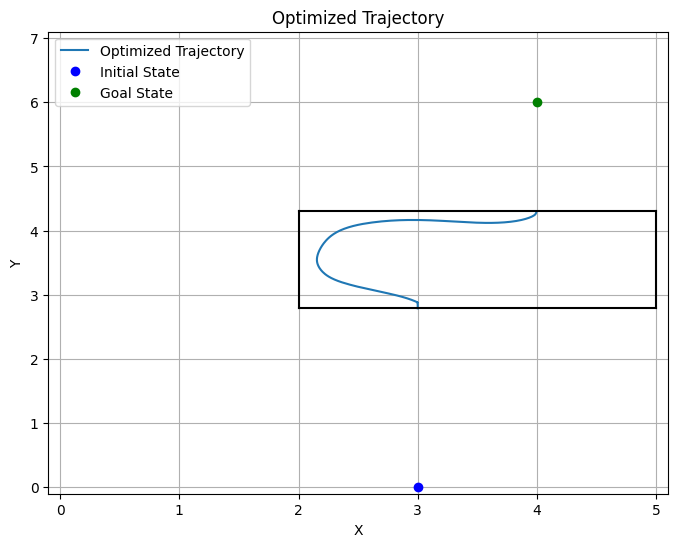

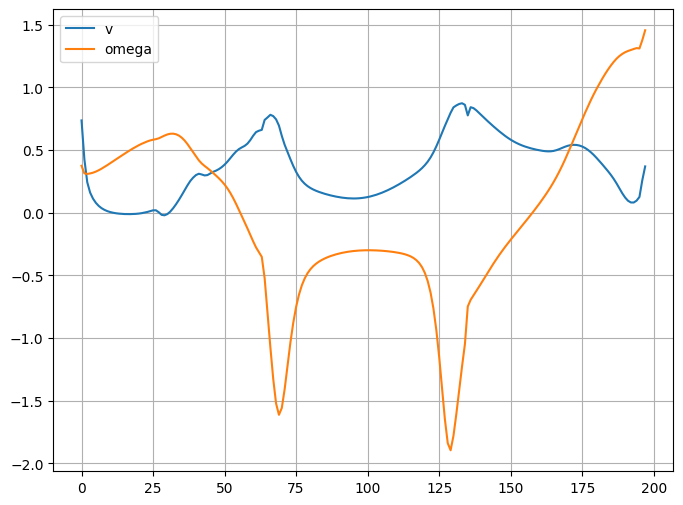

In [92]:
start = traj_opt_node.current_state_
goal = traj_opt_node.goal_state_
# Plot the trajectory
plt.figure(figsize=(8,6)) # Adjust figure size if needed
plt.plot(X[0, :-1], X[1, :-1], label='Optimized Trajectory')

# Plot the initial state
plt.plot(start[0], start[1], 'bo', label='Initial State')
# Plot the goal state
plt.plot(goal[0], goal[1], 'go', label='Goal State')


# Plot the obstacle
x_min_obs = 2.0
x_max_obs = 5.0
y_min_obs = 2.8
y_max_obs = 4.3
plt.plot([x_min_obs, x_min_obs], [y_min_obs, y_max_obs], color='black')
plt.plot([x_min_obs, x_max_obs], [y_max_obs, y_max_obs], color='black')
plt.plot([x_max_obs, x_max_obs], [y_max_obs, y_min_obs], color='black')
plt.plot([x_max_obs, x_min_obs], [y_min_obs, y_min_obs], color='black')

# Plot the obstacle
x_obs = 3.0
y_obs = 3.0
r_obs = 1.0
theta = np.linspace(0, 2*np.pi, 100)
x_circle = x_obs + r_obs * np.cos(theta)
y_circle = y_obs + r_obs * np.sin(theta)
# plt.plot(x_circle, y_circle, color='black')


# Optional: Customize plot
plt.xlabel('X') 
plt.ylabel('Y')



# limit the axis
plt.xlim([-0.1, 5.1])
plt.ylim([-0.1, 7.1])
plt.title('Optimized Trajectory')
plt.grid(True)
plt.legend()

# Plot the trajectory
plt.figure(figsize=(8,6)) # Adjust figure size if needed
plt.plot(U[0, :-2], label='v')
plt.plot(U[1,:-2], label='omega')

# Optional: Customize plot
plt.grid(True)
plt.legend()

# Show the plot
plt.show() 